<a href="https://colab.research.google.com/github/thinkdeepai/reinforcement-learning-training/blob/master/colab_gym_keras_rl_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   30G  311G   9% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G   12K  6.4G   1% /var/colab
/dev/sda1       365G   31G  335G   9% /opt/bin
shm             5.9G  4.0K  5.9G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [3]:
!mkdir project
!ls

project  sample_data


In [0]:
!cd sample_data

In [5]:
import keras
keras.__version__

'2.2.5'

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6792869208245600601, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15435507235551530165
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5935219050307161035
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15991503067476384172
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
from google.colab import files
uploaded = files.upload()

In [7]:
!pip install gym keras-rl pyglet==1.2.4
!apt-get install -y cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install 'gym[all]'

     |████████████████████████████████| 40kB 3.6MB/s 
     |████████████████████████████████| 972kB 17.5MB/s 
  Created wheel for keras-rl: filename=keras_rl-0.4.2-cp36-none-any.whl size=48379 sha256=ae2aa102637dd521330f25d24b0b22e7756bdd1d475997feff1427fb5e6a98d0
  Stored in directory: /root/.cache/pip/wheels/7d/4d/84/9254c9f2e8f51865cb0dac8e79da85330c735551d31f73c894
Successfully built keras-rl
  Found existing installation: pyglet 1.3.2
    Uninstalling pyglet-1.3.2:
      Successfully uninstalled pyglet-1.3.2
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libboost-all-dev is already the newest version (1.65.1.0ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.

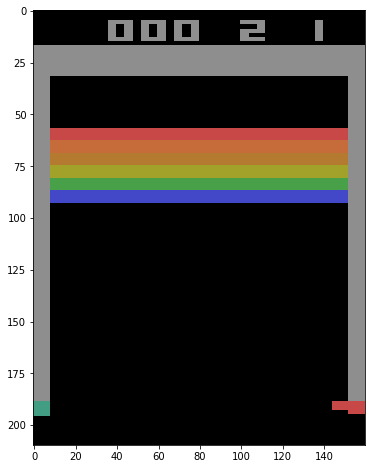

In [0]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('Breakout-v0')
env.reset()

plt.figure(figsize=(6,8))
img = plt.imshow(env.render(mode='rgb_array'))

for _ in range(100):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
env.close()

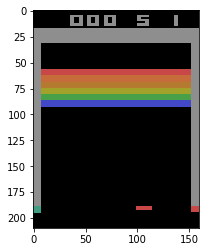

In [0]:
# import gym
# from IPython import display
# import matplotlib.pyplot as plt
# %matplotlib inline

env = gym.make('Breakout-v0')
env.reset()

plt.imshow(env.render(mode='rgb_array'))

In [1]:
from PIL import Image
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint


INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

ENV_NAME = 'BreakoutDeterministic-v4'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
#print(model.summary())

memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

dqn.compile(Adam(lr=.00025), metrics=['mae'])

Using TensorFlow backend.


ModuleNotFoundError: ignored

# TRAIN

In [0]:
weights_filename = 'dqn_{}_weights.h5f'.format(ENV_NAME)
checkpoint_weights_filename = 'dqn_' + ENV_NAME + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(ENV_NAME)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
dqn.fit(env, callbacks=callbacks, nb_steps=1750000, log_interval=10000)

dqn.save_weights(weights_filename, overwrite=True)
dqn.test(env, nb_episodes=1, visualize=False)

# TEST:1

Episode 1: reward: 37.000, steps: 1185
END


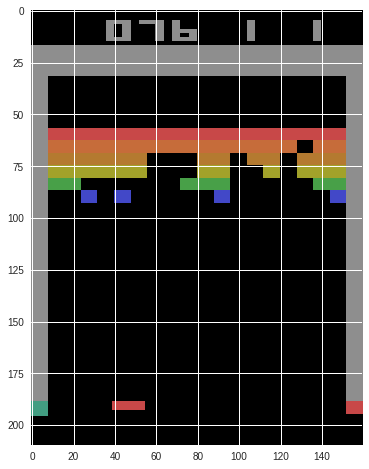

In [0]:
from rl.callbacks import Callback
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# Subclass to visualize on Jupyter Notebook, inherits from rl.callbacks.Callback Class
class Render(Callback):
    def on_step_end(self, step, logs={}):
        plt.clf()
        plt.imshow(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

# weights_filename = 'dqn_{}_weights.h5f'.format(ENV_NAME)
# weights_filename = 'dqn_{}_weights_1750000.h5f'.format(ENV_NAME) # @check point
weights_filename = 'dqn_BreakoutDeterministic-v4_weights_1750000.h5f'
dqn.load_weights(weights_filename)

callbacks = Render()
plt.figure(figsize=(6,8))
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[callbacks])

env.close()
print('END')

In [0]:
from rl.callbacks import Callback
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

ims = []  # list for animation

class Render(Callback):
    def on_step_end(self, step, logs={}):
        im = plt.imshow(env.render(mode='rgb_array'))
        ims.append([im])

#weights_filename = 'dqn_{}_weights.h5f'.format(ENV_NAME)
weights_filename = 'dqn_BreakoutDeterministic-v4_weights_1750000.h5f'
dqn.load_weights(weights_filename)

callbacks = Render()
fig = plt.figure(figsize=(4,5)) # output size
plt.axis('off')                 # no frame
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[callbacks])

ani = animation.ArtistAnimation(fig=fig, artists=ims, interval=10)
# ani.save("anim.gif", writer = "imagemagick") # save as gif animation
plt.close()

# animation on Jupyter Notebook
HTML(ani.to_jshtml())        # JavascriptHTML output
#HTML(ani.to_html5_video())  # HTML5 Video output